In [48]:
from tsai.all import *
my_setup()

os              : Windows-10-10.0.26100-SP0
python          : 3.10.0
tsai            : 0.4.0
fastai          : 2.7.19
fastcore        : 1.7.29
torch           : 2.5.1+cpu
device          : cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.86 GB
GPU memory      : [6.0] GB


In [49]:
full_tgt_dir = "./data/tsai"
STRIDE = None
HORIZON = 1
window_length = 100
target_dir = full_tgt_dir
train_file = "./data/HouseholdPowerConsumption1_TRAIN_dim0.csv"
test_file = "./data/HouseholdPowerConsumption1_TEST_dim0.csv"
generate_split = True
print(train_file)

./data/HouseholdPowerConsumption1_TRAIN_dim0.csv


In [50]:
df_train = pd.read_csv(train_file, sep=",", header=None, index_col=0) # type: ignore
df_train.fillna(df_train.median(), inplace=True) # type: ignore
df_test = pd.read_csv(test_file, sep=",", header=None, index_col=0) # type: ignore
df_test.fillna(df_test.median(), inplace=True) # type: ignore
print(f"Dataset name: {train_file}. Dataset shape: {df_train.shape}.")
print(f"Dataset name: {test_file}. Dataset shape: {df_test.shape}.")
try:
    X_train, y_train = SlidingWindow(window_length, horizon=HORIZON, stride=STRIDE)(df_train)
    print(f"X train shape {X_train.shape}, y train shape {y_train.shape}")
    X_test, y_test = SlidingWindow(window_length, horizon=HORIZON, stride=STRIDE)(df_test)
    print(f"X test shape {X_test.shape}, y test shape {y_test.shape}")
except Exception as e:
    print(f"Could not generate X, y pair from Pandas dataframe: {e}")
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
print(X.shape)
print(y.shape)
print(y[:10])

Dataset name: ./data/HouseholdPowerConsumption1_TRAIN_dim0.csv. Dataset shape: (1072800, 1).
Dataset name: ./data/HouseholdPowerConsumption1_TEST_dim0.csv. Dataset shape: (987840, 1).
X train shape (10727, 1, 100), y train shape (10727,)
X test shape (9878, 1, 100), y test shape (9878,)
(20605, 1, 100)
(20605,)
[241.92 243.27 243.14 244.35 241.86 238.03 237.94 240.48 243.11 237.75]


X      - shape: [20605 samples x 1 features x 100 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (20605,)  type: ndarray  dtype:float64  isnan: 0
splits - n_splits: 2 shape: [10727, 9878]  overlap: False


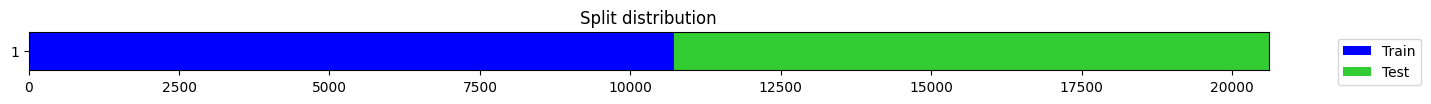

In [51]:
check_data(X, y, splits)

In [59]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:128, vars:1, len:100, device=cpu, dtype=torch.float32),
 tensor([239.7300, 243.9100, 245.0400, 238.2800, 244.4800, 241.2800, 237.2700,
         242.8900, 242.6600, 233.8600, 234.7700, 243.9600, 240.7100, 241.8800,
         244.8200, 241.4100, 236.9400, 245.4600, 243.4500, 240.2300, 234.9200,
         238.3800, 237.8600, 244.0200, 236.0800, 237.7900, 241.8200, 235.7400,
         239.1400, 239.1600, 240.8500, 238.3100, 239.9600, 235.1500, 243.7300,
         237.4400, 241.2400, 245.5000, 238.9900, 240.1000, 237.4500, 239.8900,
         240.2500, 241.2200, 238.8400, 249.4000, 243.5500, 241.7100, 238.7600,
         239.9600, 238.4200, 242.6300, 241.3200, 246.7000, 243.6300, 242.2600,
         242.0500, 242.2200, 242.1800, 241.6500, 241.9100, 238.0900, 238.5300,
         244.9200, 237.0300, 244.3500, 238.2500, 237.8500, 238.0300, 232.6700,
         239.2400, 237.1900, 240.1400, 236.9100, 239.9400, 234.7200, 239.4300,
         240.6900, 243.3300, 239.7500, 237.1700, 243.8400

dls.c 1
None


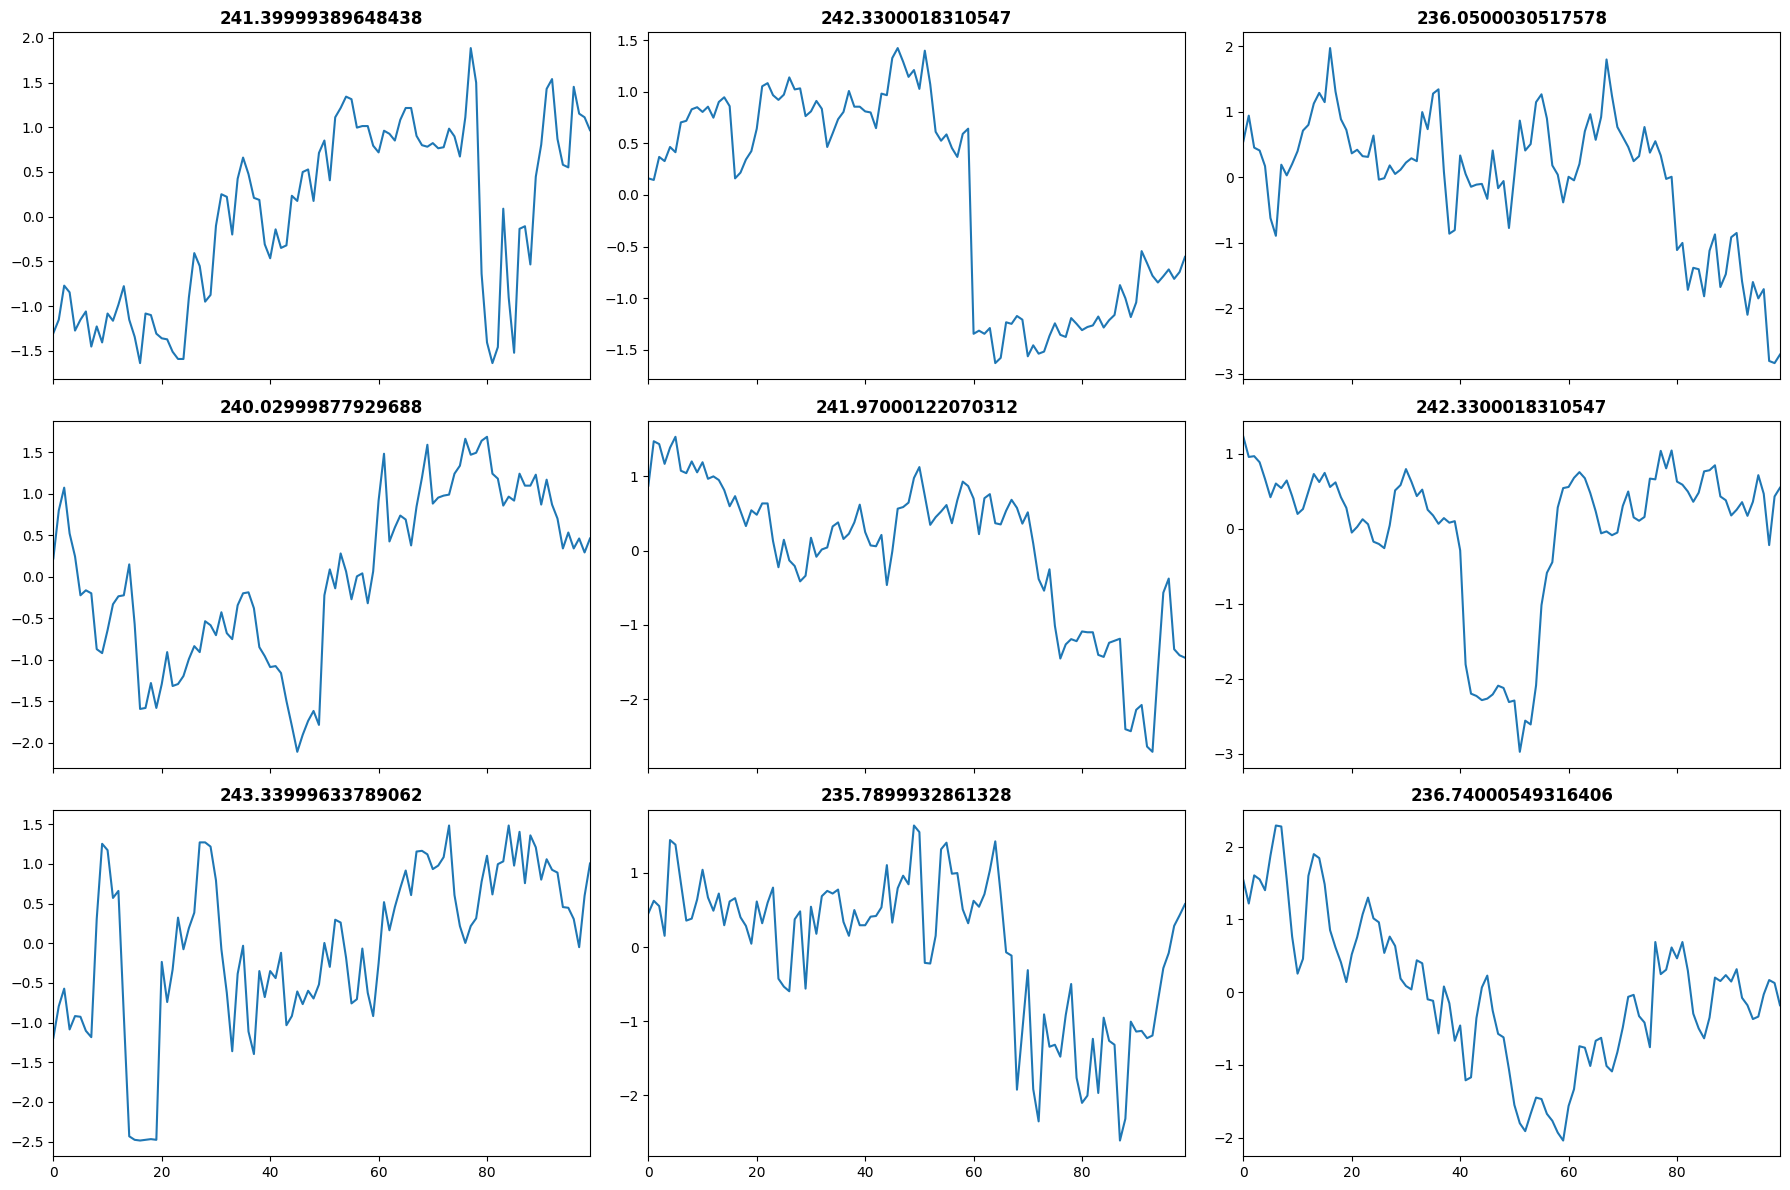

In [53]:
print(f"dls.c {dls.c}")
print(dls.show_batch())

75
tensor([6.3096e-07, 7.5858e-07, 9.1201e-07, 1.0965e-06, 1.3183e-06, 1.5849e-06,
        1.9055e-06, 2.2909e-06, 2.7542e-06, 3.3113e-06, 3.9811e-06, 4.7863e-06,
        5.7544e-06, 6.9183e-06, 8.3176e-06, 1.0000e-05, 1.2023e-05, 1.4454e-05,
        1.7378e-05, 2.0893e-05, 2.5119e-05, 3.0200e-05, 3.6308e-05, 4.3652e-05,
        5.2481e-05, 6.3096e-05, 7.5858e-05, 9.1201e-05, 1.0965e-04, 1.3183e-04,
        1.5849e-04, 1.9055e-04, 2.2909e-04, 2.7542e-04, 3.3113e-04, 3.9811e-04,
        4.7863e-04, 5.7544e-04, 6.9183e-04, 8.3176e-04, 1.0000e-03, 1.2023e-03,
        1.4454e-03, 1.7378e-03, 2.0893e-03, 2.5119e-03, 3.0200e-03, 3.6308e-03,
        4.3652e-03, 5.2481e-03, 6.3096e-03, 7.5858e-03, 9.1201e-03, 1.0965e-02,
        1.3183e-02, 1.5849e-02, 1.9055e-02, 2.2909e-02, 2.7542e-02, 3.3113e-02,
        3.9811e-02, 4.7863e-02, 5.7544e-02, 6.9183e-02, 8.3176e-02, 1.0000e-01,
        1.2023e-01, 1.4454e-01, 1.7378e-01, 2.0893e-01, 2.5119e-01, 3.0200e-01,
        3.6308e-01, 4.3652e-01, 5.248

SuggestedLRs(valley=0.0008317637839354575)

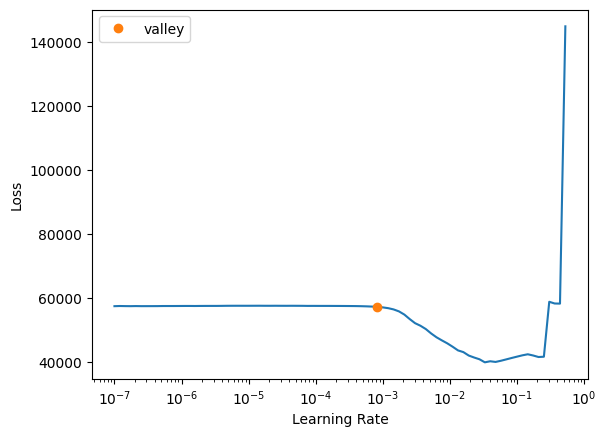

In [54]:
learn = ts_learner(dls=dls, arch=MLP, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,56889.507812,272516.500000,282.071960,522.031128,00:01
1,46830.207031,44676524.000000,839.139648,6684.050293,00:01
2,13308.374023,430390208.000000,2091.796143,20745.847656,00:01
3,3264.284180,586421504.000000,2416.166260,24216.144531,00:01
4,1024.357178,647125312.000000,2532.417969,25438.660156,00:01
5,496.691101,675464576.000000,2586.116211,25989.701172,00:01
6,345.689514,702593536.000000,2638.550537,26506.480469,00:01
7,301.984924,705019648.000000,2641.714600,26552.208984,00:01
8,269.194092,710755264.000000,2653.042969,26659.994141,00:01
9,258.556213,728196032.000000,2689.440674,26985.109375,00:01


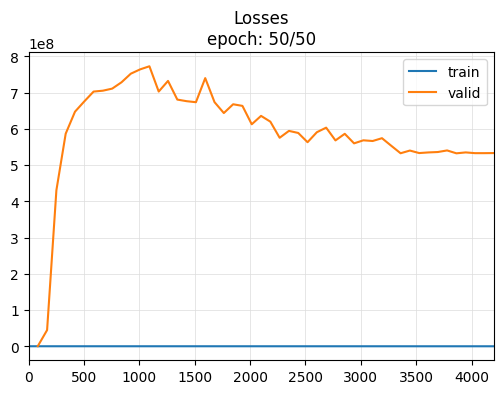

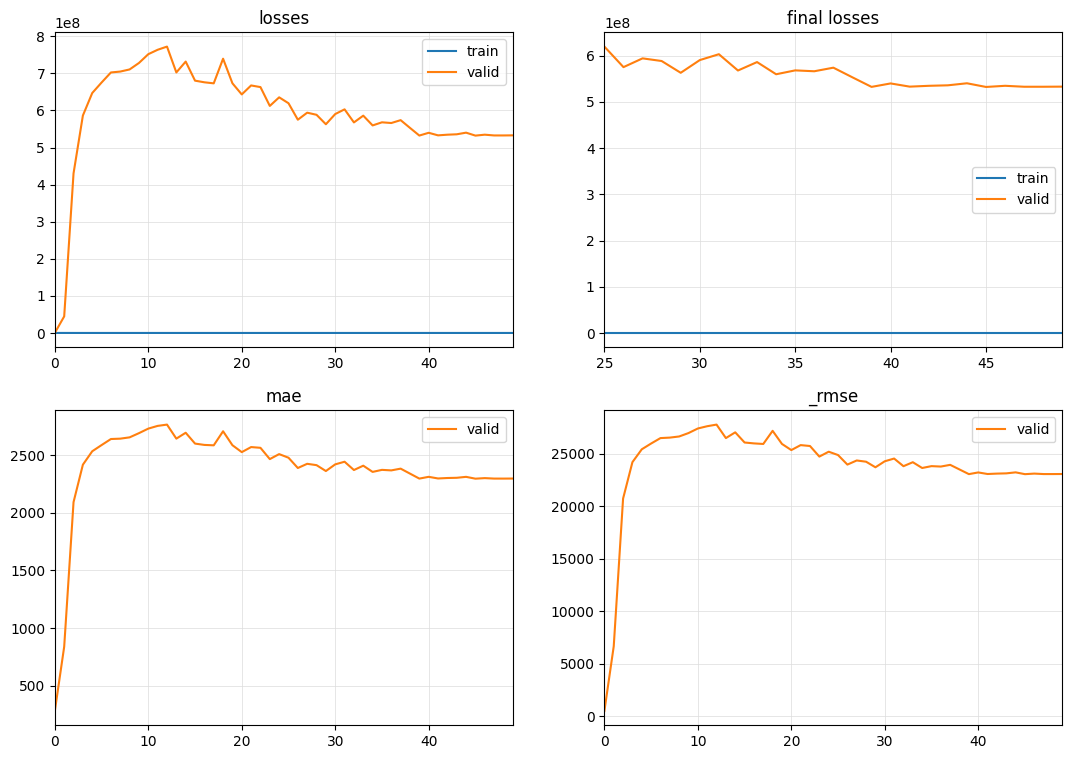

In [55]:
learn.loss_func
learn.fit_one_cycle(50, 0.0008317637839354575)

In [56]:
PATH = Path('./models/Regression.pkl')
PATH.parent.mkdir(parents=True, exist_ok=True)
learn.export(PATH)
del learn

In [57]:
PATH = Path('./models/Regression.pkl')
learn = load_learner(PATH, cpu=False)

In [58]:
probas, _, preds = learn.get_X_preds(X[splits[1]])
skm.root_mean_squared_error(y[splits[1]], preds)

23086.010540120813